# Some plots

## Distributions of training- and test data

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [118]:
df_train = pd.read_csv("../../data/dataset_train.csv")
df_test = pd.read_csv("../../data/dataset_test.csv")

In [119]:
counts_test = df_test.groupby("label")["label"].count()
label_test = counts_test.index
counts_test = counts_test.values

counts_train = df_train.groupby("label")["label"].count()
label_train = counts_train.index
counts_train = counts_train.values

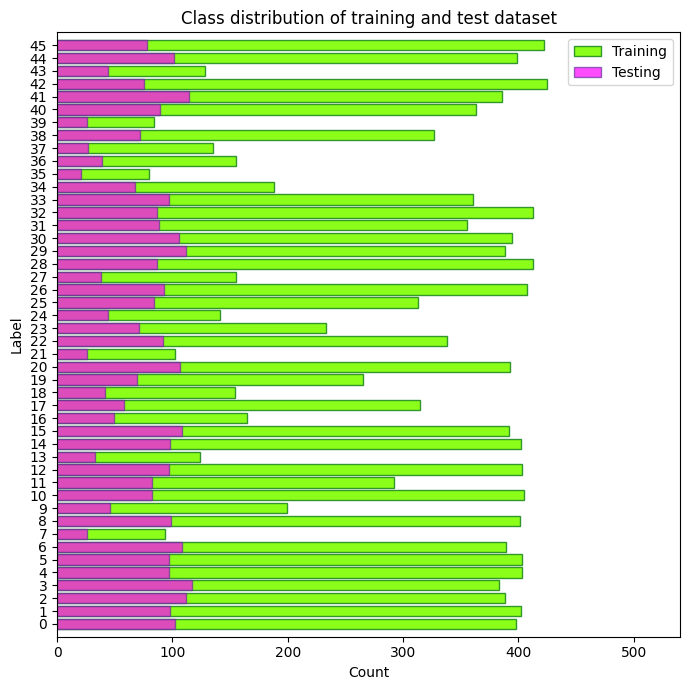

In [123]:
plt.figure(figsize = (7,7))
plt.title("Class distribution of training and test dataset")
plt.barh(label_train, counts_train, color = "chartreuse", label = "Training", edgecolor = "forestgreen", alpha = .9) # tu green "#639A00"
plt.barh(label_test, counts_test, color = "fuchsia", label = "Testing", edgecolor = "rebeccapurple", alpha = .7) # tu orange "#CA7406"
plt.xlabel('Count')
plt.ylabel('Label')
plt.xlim(0, 540)
plt.ylim(-1, 46)
plt.yticks(range(0, 46),range(0, 46))
plt.legend()
plt.tight_layout()

In [133]:
length_test = df_test.groupby("label")["length_seconds"].sum()
label_test = length_test.index
length_test = length_test.values

length_train = df_train.groupby("label")["length_seconds"].sum()
label_train = length_train.index
length_train = length_train.values

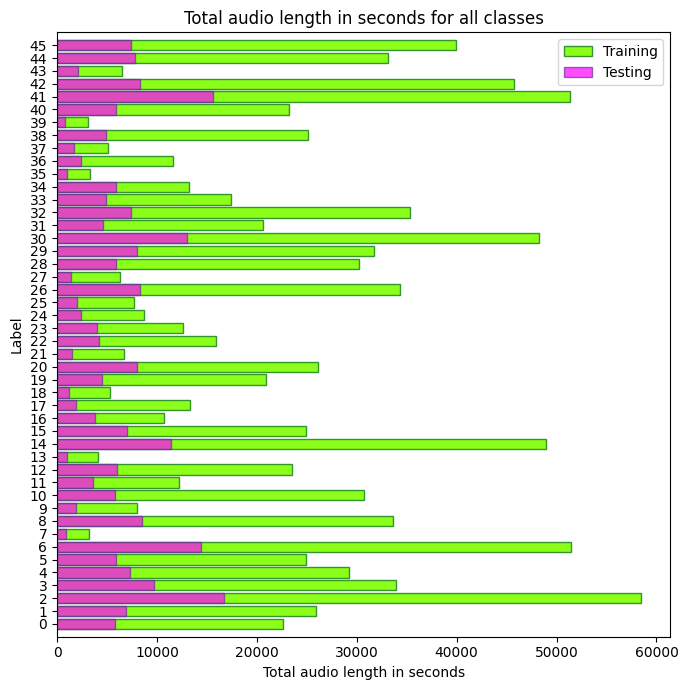

In [134]:
plt.figure(figsize = (7,7))
plt.title("Total audio length in seconds for all classes")
plt.barh(label_train, length_train, color = "chartreuse", label = "Training", edgecolor = "forestgreen", alpha = .9) # tu green "#639A00"
plt.barh(label_test, length_test, color = "fuchsia", label = "Testing", edgecolor = "rebeccapurple", alpha = .7) # tu orange "#CA7406"
plt.xlabel('Total audio length in seconds')
plt.ylabel('Label')
#plt.xlim(0, 540)
plt.ylim(-1, 46)
plt.yticks(range(0, 46),range(0, 46))
plt.legend()
plt.tight_layout()

In [125]:
length_test = df_test.groupby("label")["length_seconds"].mean()
label_test = length_test.index
length_test = length_test.values

length_train = df_train.groupby("label")["length_seconds"].mean()
label_train = length_train.index
length_train = length_train.values

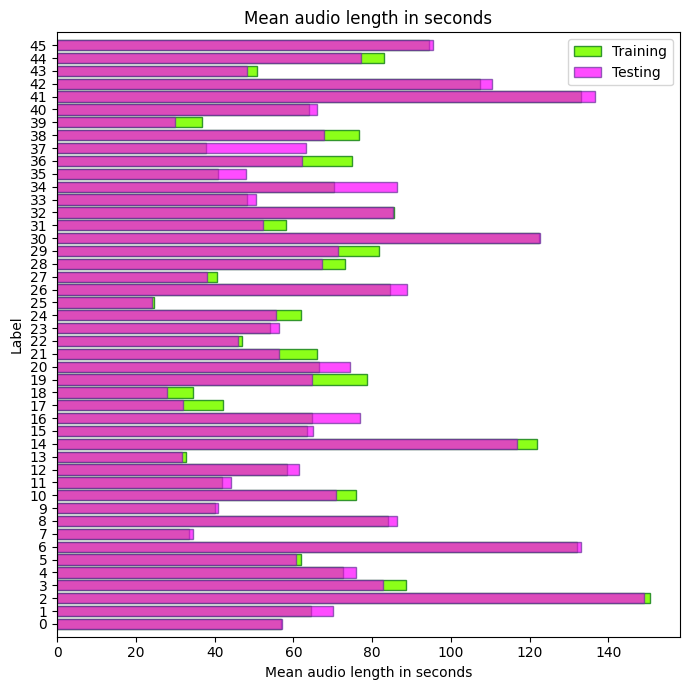

In [132]:
plt.figure(figsize = (7,7))
plt.title("Mean audio length in seconds")
plt.barh(label_train, length_train, color = "chartreuse", label = "Training", edgecolor = "forestgreen", alpha = .9) # tu green "#639A00"
plt.barh(label_test, length_test, color = "fuchsia", label = "Testing", edgecolor = "rebeccapurple", alpha = .7) # tu orange "#CA7406"
plt.xlabel('Mean audio length in seconds')
plt.ylabel('Label')
#plt.xlim(0, 540)
plt.ylim(-1, 46)
plt.yticks(range(0, 46),range(0, 46))
plt.legend()
plt.tight_layout()